# Checkpoint 8: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones on `AEs`. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10AM Friday** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-01-19 21:52:57.219065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Keras import(s)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

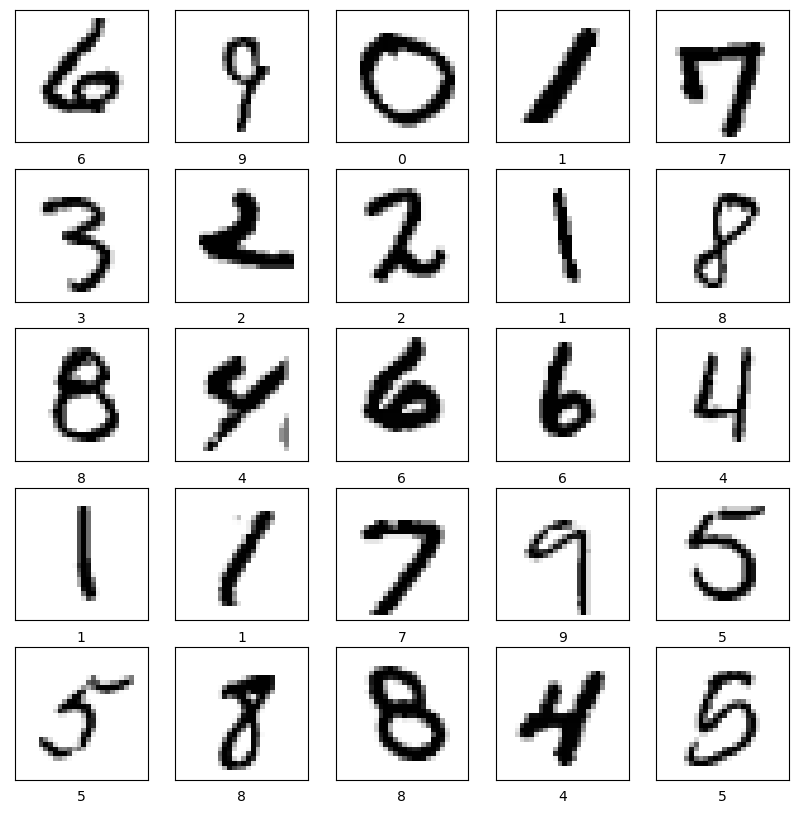

label marks [6 9 0 1 7 3 2 2 1 8 8 4 6 6 4 1 1 7 9 5 5 8 8 4 5]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [5]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [6]:
intermediate_dim =256
latent_dim = 2

In [7]:
encoder_inputs = Input(shape=(28,28,1), name="input")
x1 = Conv2D(16, kernel_size=(3,3), padding="same", activation="relu")(encoder_inputs)
x2 = MaxPooling2D(pool_size=(2,2))(x1)
x3 = Conv2D( 8, kernel_size=(3,3), padding="same", activation="relu")(x2)
e = Flatten()(x3)
x = Dense(intermediate_dim, activation="relu")(e)
x = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(latent_dim, ), name="z")([z_mean,z_log_var])
outputs = [z_mean, z_log_var, z]
encoder = Model(encoder_inputs, outputs, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 8)    1160        ['max_pooling2d[0][0]']          
                                                                                            

# Nice model 

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [8]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation="relu")(latent_inputs)
x = Dense(intermediate_dim, activation="relu")(x)
x = Dense(14*14*8, activation="relu")(x)
x = Reshape((14, 14, 8))(x)
x = Conv2DTranspose(16, kernel_size=(3,3), padding="same", activation="relu")(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2DTranspose(8, kernel_size=(3,3), padding="same", activation="relu")(x)
outputs = Conv2DTranspose(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 256)               768       
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1568)              402976    
                                                                 
 reshape (Reshape)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 16)       1168      
 nspose)                                                         
                                                           

# Looks good 

#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

In [9]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
    i = i[0]
    pass
z = encoder(i)[2]
o = decoder(z)

In [10]:
vae = Model(i, o,name="VAE")

In [11]:
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               469804    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         471937    
                                                                 
Total params: 941,741
Trainable params: 941,741
Non-trainable params: 0
_________________________________________________________________


# Might be a lot of parameters to train but otherwise looks okay 

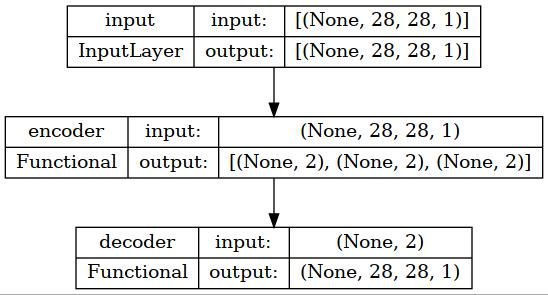

In [12]:
plot_model(vae, to_file = "vae.jpg", show_shapes = True, show_layer_names = True)

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [13]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Compile the model.
* Train for ca. **50 epochs**.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [14]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [15]:
compile_vae(vae)

In [16]:
history = vae.fit(X_train,X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples


2023-01-19 21:53:03.674053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 21:53:03.698796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/50
48000/48000 [==============================] - ETA: 0s - loss: 193.0362 - reco_loss: 189.4236 - kl_loss: 3.6126

/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 17s 350us/sample - loss: 193.0362 - reco_loss: 189.4236 - kl_loss: 3.6126 - val_loss: 167.7995 - val_reco_loss: 163.0262 - val_kl_loss: 4.7733
Epoch 2/50
48000/48000 [==============================] - 17s 346us/sample - loss: 161.3915 - reco_loss: 156.2536 - kl_loss: 5.1379 - val_loss: 158.2976 - val_reco_loss: 153.0482 - val_kl_loss: 5.2494
Epoch 3/50
48000/48000 [==============================] - 17s 347us/sample - loss: 155.2564 - reco_loss: 149.7075 - kl_loss: 5.5489 - val_loss: 154.3381 - val_reco_loss: 148.6319 - val_kl_loss: 5.7063
Epoch 4/50
48000/48000 [==============================] - 17s 349us/sample - loss: 152.2742 - reco_loss: 146.5059 - kl_loss: 5.7683 - val_loss: 152.3644 - val_reco_loss: 146.8031 - val_kl_loss: 5.5613
Epoch 5/50
48000/48000 [==============================] - 17s 349us/sample - loss: 150.1859 - reco_loss: 144.2785 - kl_loss: 5.9074 - val_loss: 150.5071 - val_reco_loss: 144.8102 - val_kl_loss: 5.6969
Epoch 

Epoch 42/50
48000/48000 [==============================] - 17s 345us/sample - loss: 135.7558 - reco_loss: 128.7449 - kl_loss: 7.0108 - val_loss: 139.9777 - val_reco_loss: 133.0226 - val_kl_loss: 6.9551
Epoch 43/50
48000/48000 [==============================] - 17s 346us/sample - loss: 135.6253 - reco_loss: 128.5885 - kl_loss: 7.0369 - val_loss: 139.9680 - val_reco_loss: 132.9128 - val_kl_loss: 7.0552
Epoch 44/50
48000/48000 [==============================] - 17s 346us/sample - loss: 135.5503 - reco_loss: 128.5326 - kl_loss: 7.0176 - val_loss: 140.3880 - val_reco_loss: 133.4656 - val_kl_loss: 6.9224
Epoch 45/50
48000/48000 [==============================] - 17s 346us/sample - loss: 135.3914 - reco_loss: 128.3531 - kl_loss: 7.0383 - val_loss: 140.6746 - val_reco_loss: 133.7708 - val_kl_loss: 6.9038
Epoch 46/50
48000/48000 [==============================] - 17s 346us/sample - loss: 135.4502 - reco_loss: 128.3945 - kl_loss: 7.0556 - val_loss: 139.6666 - val_reco_loss: 132.8317 - val_kl_los

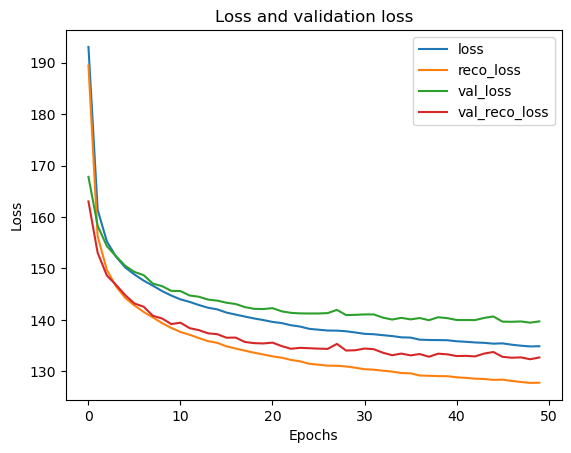

In [17]:
plt.plot(vae.history.history["loss"],label="loss")
plt.plot(vae.history.history["reco_loss"],label="reco_loss")
plt.plot(vae.history.history["val_loss"],label="val_loss")
plt.plot(vae.history.history["val_reco_loss"],label="val_reco_loss")
plt.title("Loss and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

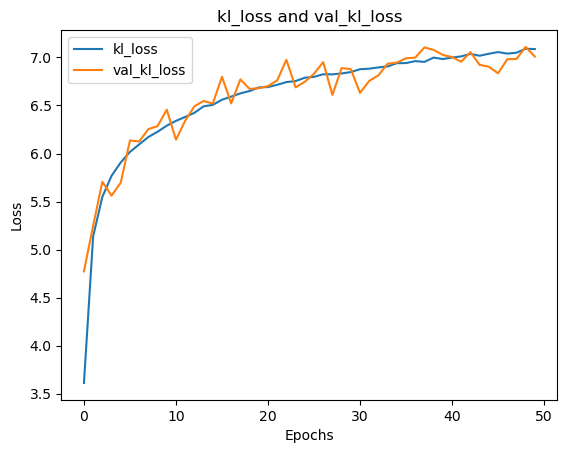

In [18]:
plt.plot(vae.history.history["kl_loss"],label="kl_loss")
plt.plot(vae.history.history["val_kl_loss"],label="val_kl_loss")
plt.title("kl_loss and val_kl_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Yes -- but please put them superimposed one 1 canvas 

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

In [19]:
z_mean, z_log_var, z = encoder.predict(X_test)

/opt/anaconda-2022.10/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


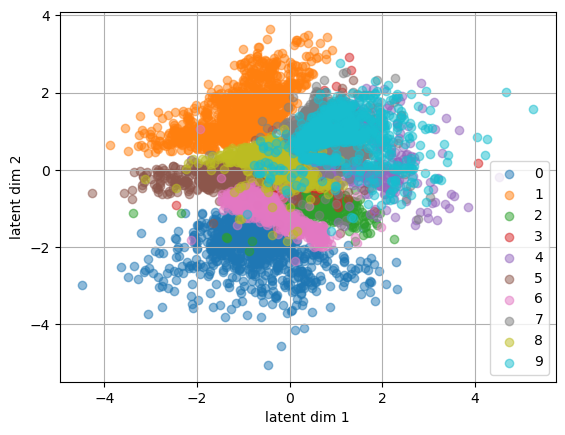

In [20]:
for num in np.unique(y_test):
    mask = np.where(y_test==num)[0]
    plt.scatter(z[:,0][mask],z[:,1][mask],alpha=0.5,label=num)
    
plt.xlabel("latent dim 1")
plt.ylabel("latent dim 2")
plt.legend()
plt.grid()
plt.show()

### Discuss the results. Why do you think some digits overlap, and why are some clearly seperated?

This plot shows where the encoder predicts the different digits within the latent space. Each of the different colours represents a given digit.

The results show that test digits are predicted into defined clusters in the 2D latent space. Digits of the same number tend to be mapped onto the same region.

The clusters formed by some digits overlap as the digits share many of the features which the network has learned about them.

On the other hand, some of the clusters are more clearly separated from the rest as the network has been able to learn many features unique to these digits, making them more distinguishable.

# Grand! Quite happy with this -- seems liek you doin't have a lot distinction between 0 and 5 it looks like, though, or is that 7? I would like more discussion about the overlaps and how it could be avoided  

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

In [21]:
X,Y = np.meshgrid(np.linspace(-2,2,10),np.linspace(-2,2,10))

In [22]:
X = X.flatten()
Y = Y.flatten()

In [23]:
latent_coords = np.array([X,-Y]).T # minus sign to get correct spatial orientation of generated images on the grid

In [24]:
gen_imgs = decoder.predict(latent_coords)

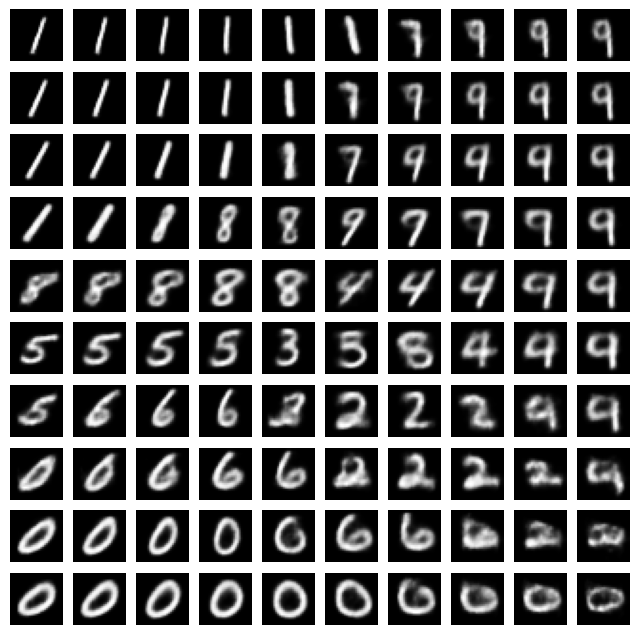

In [25]:
plt.figure(figsize=(8,8))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis("off")
    plt.imshow(gen_imgs[i],cmap=plt.cm.binary_r)
    
plt.show()

### Discuss the results

A range of equally spaced coordinate values were selected within a region of the latent space which represents a square with length 4 centered on the origin and parallel with the axes. 

The latent space coordinates were then fed to a decoder which generated images based on the features that were encoded within those points in the latent space. 

These set of generated images show that as we move around regions in the latent space the features that are encoded produce different digits, with some digits being clearly decoded and others being quite ambiguous.

The distinctly generated digits correspond to regions at the centre of pure digit clusters that are well separated. These regions have a clear encoding which contains the features of only a single digit (such as 0 and 1 at the bottom-left and top-left corners in the grid respectively).

The less legibly generated digits correspond to regions at the boundary of different clusters, where multiple digit representations lie. At these regions the encoding is quite ambiguous, storing a mixture of features from different digits (such as 9 and 4, 6 and 0).

# Nice well done and good interaction with the code and the outputs -- I can tell you're really thinking about it 

# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [48]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
   
    - What is the purpose of the discriminator?

The purpose of the discriminator network is to try and distinguish between real images from the MNIST dataset and fake images that are created by the generator model.

    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    
The structure of the discriminator network consists of two convolutional layers each followed by a leaky relu and dropout layer. The final image representation is then flattened and passed to a single output node with the sigmoid activation function to predict whether the given image is real or fake.   

The convolutional layer has 64 (3,3) kernels to that are trained and used to pick out important images features. 

The leaky relu layer consists of an activation function that acts on the convolved image to down scale the negative values while unaltering the positive values. The dropout layer

The dropout layer randomly sets values of the convolved and leaky relu treated image to zero with a given rate. The image pixel values are rescaled by 1/(1-rate) to make sure the sum of pixel values remains the same after performing dropout. 
    
    
    - Why is binary crossentropy used as the loss function?
    
The binary crossentropy function is used as the loss function as it is suitable for training in a binary classification problem.

# yeah all good! 

In [49]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

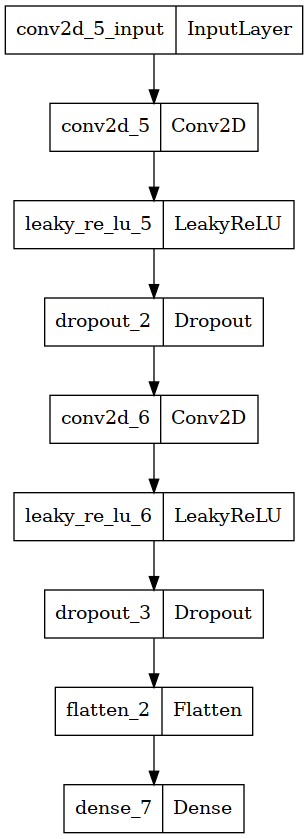

In [50]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?

A random noise image.
    
    - What is the Conv2DTranspose layer used for?

The Conv2DTranspose layer is used as part of decoding data from a random noise image in order to create features so that a meaningful image can be constructed.    
    
    - Why is sigmoid used as the activation function?
    
A sigmoid activation function is used to make sure the output image pixel values are in the range between 0 and 1.

# Good! 

In [51]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

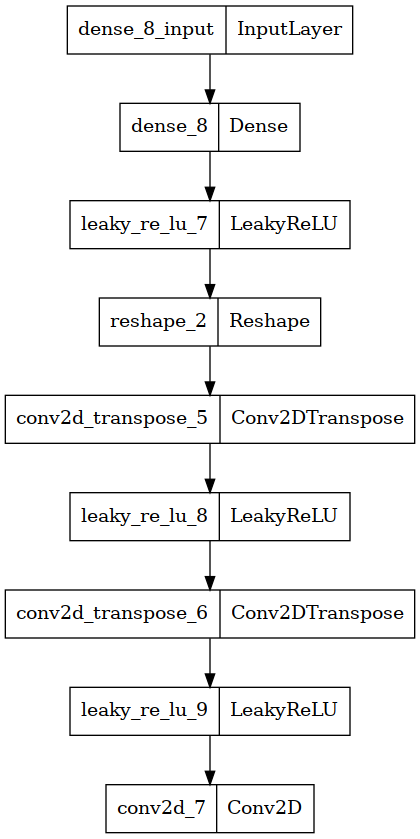

In [52]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator

1. The untrained generator is first used to create an image from an input of random noise. **(input noise, output fake image)**

2. The untrained discriminator is then used to classify the generated images as either real or fake. **(input real and fake images, output 0 (fake) or 1 (real) prediction)**

3. The discriminator loss is calculated by comparing the discriminator's predictions on real images (where output should be 1) to an array of 1s and the predictions of the fake images (where output should be 0) to an array of 0s.

4. The generator loss is then calcuated by using the combined gan model. The trained discriminator is used to make prediction on outputs from the generator when the generator is given input of random noise. The predictions of the discriminator are then compared to an array of 1s to calculate the generator loss.

5. The training loop proceeds with the generator taking another set of random noise images to produce fake images. **(input noise, output fake image)**

6. The discriminator is then used to classify real and the generated fake images. **(input real and fake images, output 0 (fake) or 1 (real) prediction)**

7. The loss is calculated for each of the models and the gradients are used to update the weights of each model.

8. The training loop is repeated until the discriminator can no longer distinguish between the real and generated fake images.
    
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.



To train the generator model the whole gan model needs to be used. This is because to calculate the generator loss (in order to train it), both the generator outputs and discriminator outputs are needed together.

However we want to just get the discriminator outputs without updating its weights, so to do this we need to "freeze" it, or in other words make it untrainable within the combined gan model. 

# Really nice! Very detailed and engaging 

In [53]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


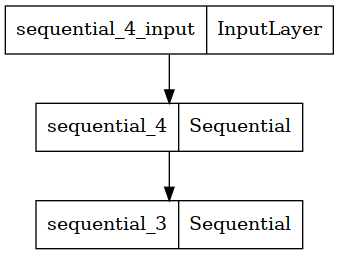

In [54]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    
The real mnist digit samples will be shuffled in with the fake generated images by the generator and be used as input to the discriminator. The goal of the discriminator is to predict 1 for real images and 0 for fake images. 

These predictions are compared to their true values and the loss for the discriminator network is computed. This is how the discriminator is trained.

The discriminator is then given just the output images from the generator and its predictions are compared to an array of 1s. This is how the loss of the generator is calculated and how the generator is trained.
    
    - what is the `y = ones((n_samples, 1))` varible used for?
    
y is set to equal a vector of 1s with the same size as the number of real samples the discriminator has to predict.

This array is used later to compare the discriminator predictions of the real samples to this array of 1s. This comparison is combined with the comparison of the discriminator predictions of the fake samples to an array of 0s. These are used together to calculate the discriminator loss.
    

In [56]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.
    
The result of feeding the random noise image and propagating it through the untrained generator is another image of random noise. 

This is because the input random noise was conv2Dtransposed using randomly initiated kernels to create random features in the image. These random features were slightly processed with the leaky relu and dropout layers but all of the pixel values were randomised again at the end by sigmoid activation function applied to each pixel value. This just creates another random image.

In [57]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [35]:
# The image output from the generator as a result inputting a random noise image.
generator_output = generate_fake_samples(g_model,latent_dim,1)

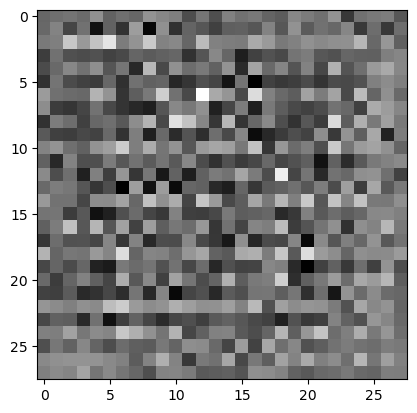

In [36]:
plt.imshow(generator_output[0][:][:][0],cmap="gray_r")
plt.show()

---
Some functions for saving GAN models and output images

In [58]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

In j loop:

<ins>Line 1.</ins> 

Loads half_batch number of real sample digits from mnist dataset into **X_real** variable.

Loads an array of 1s with size of number of real samples in **y_real** variable.

<ins>Line 2.</ins> 

Loads half_batch number output images of the generator when the generator is input random noise images into **X_fake** variable.

Loads an array of 0s with size of number of fake samples in **y_fake** variable.

<ins>Line 3.</ins> 

Combine both real and fake images into a single set and store in **X** variable.

Combine both arrays of 1s and 0s into a single array and store in **y** variable.

<ins>Line 4.</ins> 

Train the discriminator model using the **X** image set of real and fake images.

Find discriminator loss by comparing predictions of discriminator to the array **y** of true classifications.

Store discriminator loss in **d_loss** variable.

<ins>Line 5.</ins> 

Generate nbatch number of random images to use as input to the generator and store in **X_gan** variable.

<ins>Line 6.</ins> 

Create array of 1s with size of nbatch and store in **y_gan** variable. This array of 1s will be used to be compared to the predictions of the discriminator to calculate the generator loss.


<ins>Line 7.</ins> 

The generator is fed with the random noise images in **X_gan** as input. The generator outputs the fake images it generates from the noise as inputs to the discriminator. The discriminator predicts whether the fake images are real or fake. The predictions of the discriminator are compared to the array of 1s stored in **y_gan** to calculate the generator loss. All of this is done through the *gan_model* function where the discriminator is just used to predict and is not trained again.

<ins>Line 8.</ins> 

The discriminator and generator losses are printed for each batch that is used for training at each epoch.


<br></br>
The discriminator and generator are trained by iteratively repeating the j loop for each epoch.

# Super detailed! I love to see this 

In [59]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		#if (i+1) % 2 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim) # save performance every epoch
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have a GPU or some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

**Discuss the print out. How do the loss functions change over time?**

The print out shows how the discriminant loss and generator loss vary over each epoch.

The print out shows that the generator and the discriminator losses oscillate with the number of epochs. First the discriminator trains and gets better (d_loss goes down, g_loss goes up), then discriminator stops training and the generator begins training to get better (d_loss goes up, g_loss goes down), then generator stops training and discriminator starts training again and the cycle continues with the losses oscillating.

In [61]:
g_model.load_weights("generator_model_003.h5")

In [62]:
generator_output_trained = generate_fake_samples(g_model,latent_dim,9)

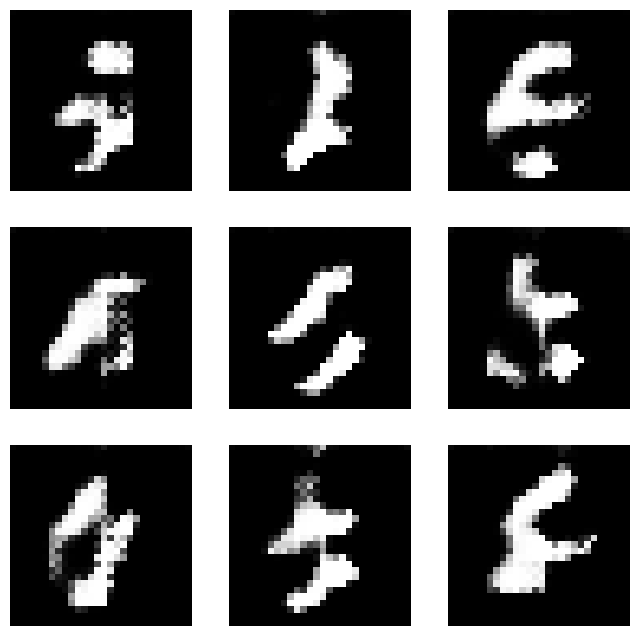

In [63]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis("off")
    plt.imshow(generator_output_trained[0][:][:][i],cmap=plt.cm.binary_r)
    
plt.show()

In [60]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=3)

>1, 1/234, d=0.691, g=0.722
>1, 2/234, d=0.681, g=0.741
>1, 3/234, d=0.671, g=0.758
>1, 4/234, d=0.664, g=0.779
>1, 5/234, d=0.660, g=0.792
>1, 6/234, d=0.652, g=0.810
>1, 7/234, d=0.642, g=0.827
>1, 8/234, d=0.637, g=0.847
>1, 9/234, d=0.635, g=0.844
>1, 10/234, d=0.633, g=0.839
>1, 11/234, d=0.640, g=0.823
>1, 12/234, d=0.642, g=0.798
>1, 13/234, d=0.642, g=0.771
>1, 14/234, d=0.647, g=0.751
>1, 15/234, d=0.645, g=0.734
>1, 16/234, d=0.642, g=0.721
>1, 17/234, d=0.635, g=0.714
>1, 18/234, d=0.629, g=0.708
>1, 19/234, d=0.625, g=0.704
>1, 20/234, d=0.619, g=0.703
>1, 21/234, d=0.609, g=0.701
>1, 22/234, d=0.601, g=0.699
>1, 23/234, d=0.591, g=0.699
>1, 24/234, d=0.584, g=0.699
>1, 25/234, d=0.568, g=0.699
>1, 26/234, d=0.561, g=0.700
>1, 27/234, d=0.557, g=0.701
>1, 28/234, d=0.544, g=0.701
>1, 29/234, d=0.529, g=0.702
>1, 30/234, d=0.521, g=0.704
>1, 31/234, d=0.512, g=0.705
>1, 32/234, d=0.503, g=0.706
>1, 33/234, d=0.485, g=0.707
>1, 34/234, d=0.482, g=0.709
>1, 35/234, d=0.472, g=

>2, 45/234, d=0.618, g=0.617
>2, 46/234, d=0.650, g=0.632
>2, 47/234, d=0.645, g=0.633
>2, 48/234, d=0.681, g=0.618
>2, 49/234, d=0.704, g=0.651
>2, 50/234, d=0.722, g=0.644
>2, 51/234, d=0.754, g=0.646
>2, 52/234, d=0.786, g=0.663
>2, 53/234, d=0.767, g=0.692
>2, 54/234, d=0.770, g=0.673
>2, 55/234, d=0.802, g=0.699
>2, 56/234, d=0.801, g=0.701
>2, 57/234, d=0.802, g=0.714
>2, 58/234, d=0.812, g=0.747
>2, 59/234, d=0.780, g=0.760
>2, 60/234, d=0.780, g=0.789
>2, 61/234, d=0.758, g=0.814
>2, 62/234, d=0.752, g=0.818
>2, 63/234, d=0.749, g=0.783
>2, 64/234, d=0.724, g=0.787
>2, 65/234, d=0.711, g=0.771
>2, 66/234, d=0.714, g=0.765
>2, 67/234, d=0.701, g=0.776
>2, 68/234, d=0.696, g=0.761
>2, 69/234, d=0.676, g=0.756
>2, 70/234, d=0.629, g=0.779
>2, 71/234, d=0.633, g=0.789
>2, 72/234, d=0.618, g=0.805
>2, 73/234, d=0.639, g=0.829
>2, 74/234, d=0.632, g=0.835
>2, 75/234, d=0.635, g=0.838
>2, 76/234, d=0.649, g=0.821
>2, 77/234, d=0.641, g=0.814
>2, 78/234, d=0.659, g=0.792
>2, 79/234, d=

>3, 89/234, d=0.657, g=0.710
>3, 90/234, d=0.673, g=0.717
>3, 91/234, d=0.677, g=0.724
>3, 92/234, d=0.678, g=0.740
>3, 93/234, d=0.673, g=0.733
>3, 94/234, d=0.666, g=0.736
>3, 95/234, d=0.673, g=0.717
>3, 96/234, d=0.678, g=0.727
>3, 97/234, d=0.688, g=0.716
>3, 98/234, d=0.683, g=0.721
>3, 99/234, d=0.682, g=0.726
>3, 100/234, d=0.683, g=0.722
>3, 101/234, d=0.691, g=0.727
>3, 102/234, d=0.691, g=0.729
>3, 103/234, d=0.697, g=0.725
>3, 104/234, d=0.689, g=0.715
>3, 105/234, d=0.690, g=0.725
>3, 106/234, d=0.690, g=0.714
>3, 107/234, d=0.696, g=0.718
>3, 108/234, d=0.686, g=0.731
>3, 109/234, d=0.702, g=0.733
>3, 110/234, d=0.700, g=0.736
>3, 111/234, d=0.686, g=0.746
>3, 112/234, d=0.708, g=0.745
>3, 113/234, d=0.693, g=0.744
>3, 114/234, d=0.691, g=0.732
>3, 115/234, d=0.705, g=0.723
>3, 116/234, d=0.695, g=0.727
>3, 117/234, d=0.698, g=0.711
>3, 118/234, d=0.687, g=0.712
>3, 119/234, d=0.703, g=0.717
>3, 120/234, d=0.706, g=0.711
>3, 121/234, d=0.710, g=0.701
>3, 122/234, d=0.690,

# Really well done on this checkpoint -- you clearly engaged a lot with this 

# TOTAL:  10/10